In [70]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
data_dir = pathlib.Path('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset')
data_dir_path = pathlib.Path(data_dir)
print(f"Dataset directory: {data_dir_path}")

Dataset directory: /content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset


In [73]:
data_dir_path

PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset')

In [74]:
len(list(data_dir.glob('*/*.jpg')))

1162

In [75]:
(list(data_dir.glob('*/*.jpg')))

[PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/4.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/9.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/22.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/18.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/10.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/21.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/2.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/15.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/freight_boat/13.jpg'),
 PosixPath('/

In [76]:
sailboats = list(data_dir.glob('sailboat/*'))
sailboats[:5]

[PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/sailboat/57.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/sailboat/208.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/sailboat/245.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/sailboat/348.jpg'),
 PosixPath('/content/drive/MyDrive/Data_for_Streamlit/boat_type_classification_dataset/sailboat/205.jpg')]

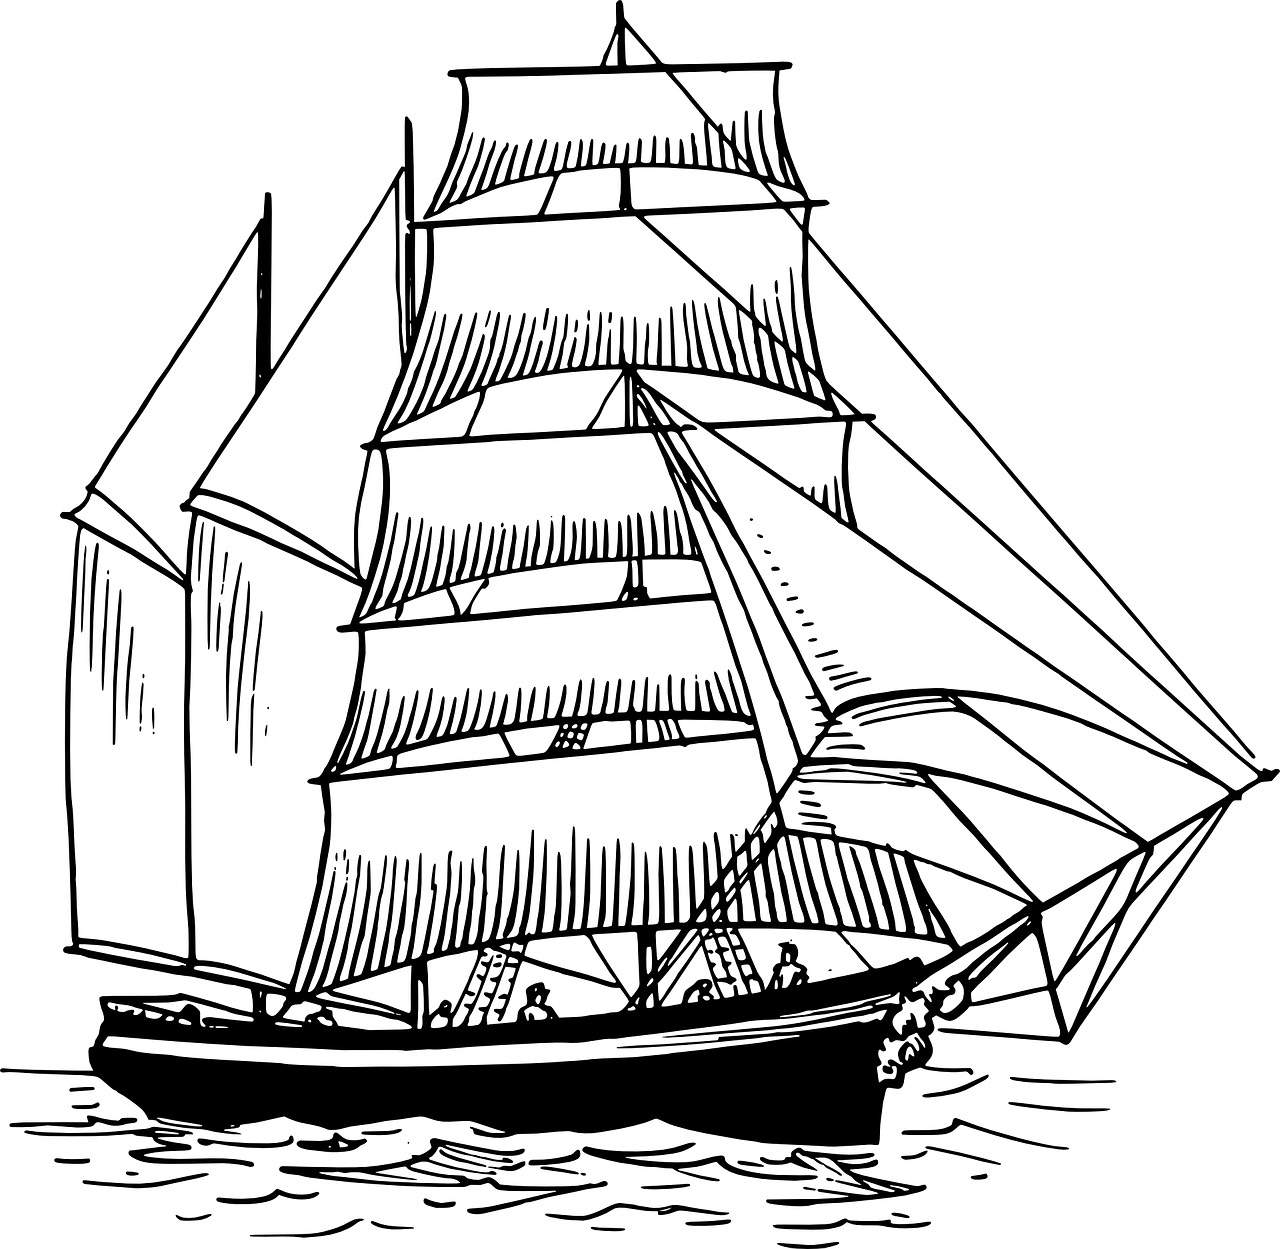

In [77]:
import PIL
PIL.Image.open(sailboats[0])

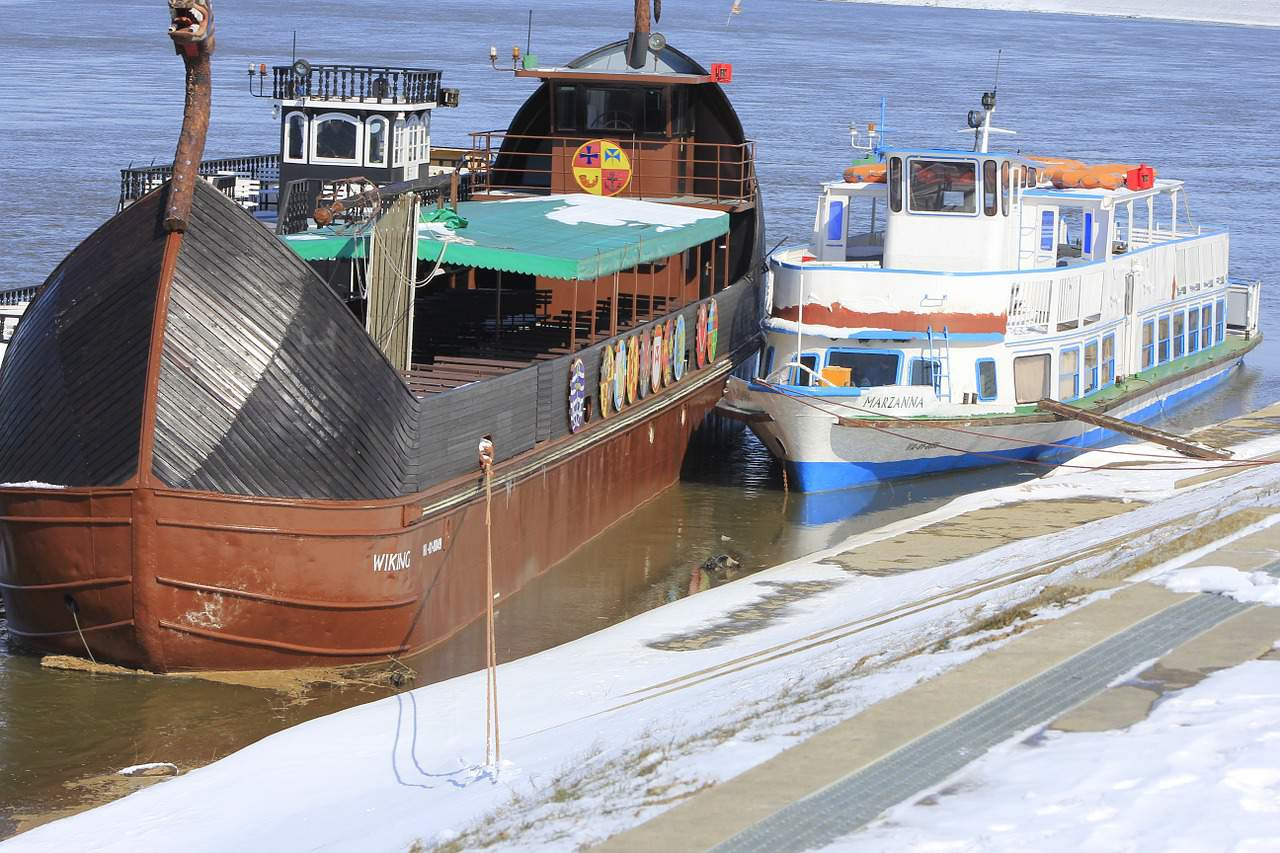

In [78]:
ferry_boats = list(data_dir.glob('ferry_boat/*'))
PIL.Image.open(ferry_boats[0])

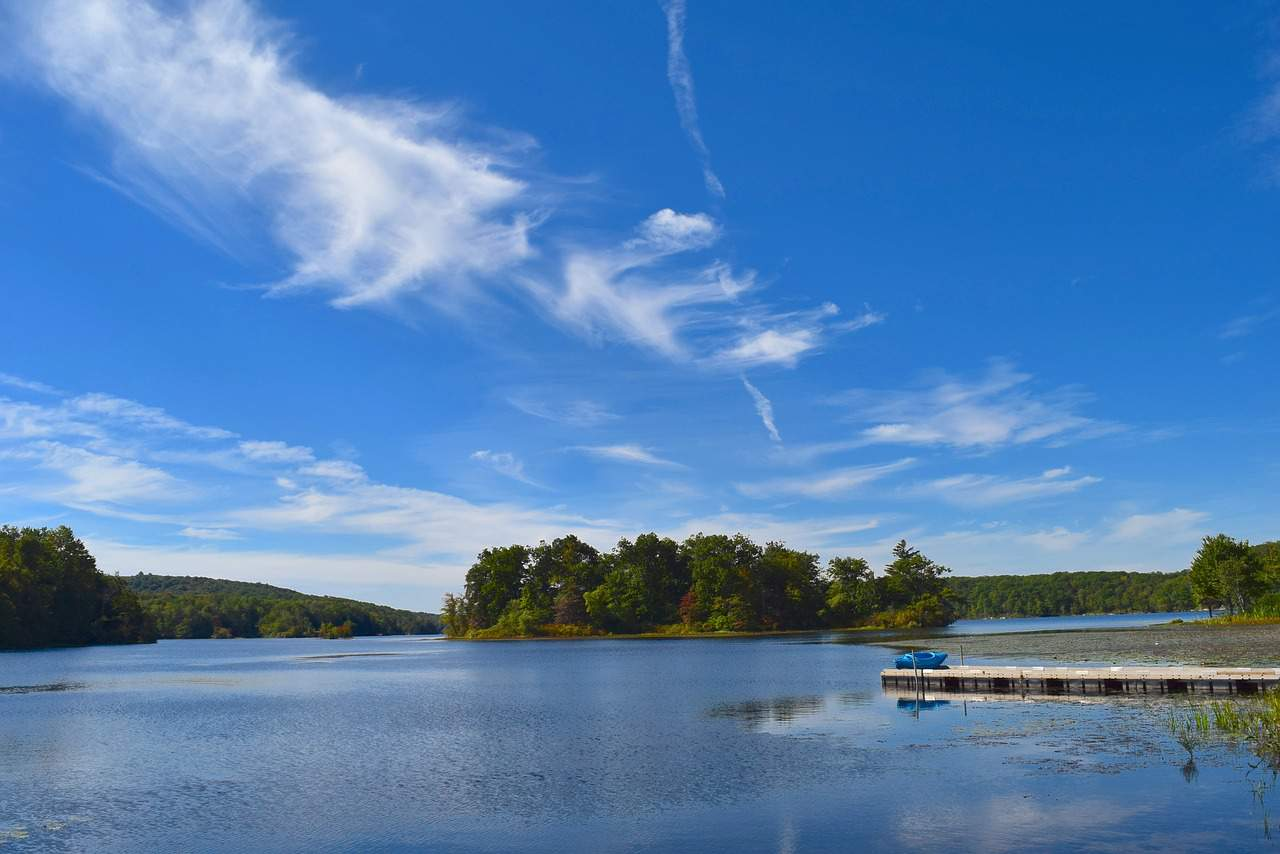

In [21]:
kayaks = list(data_dir.glob('kayak/*'))
PIL.Image.open(kayaks[0])

In [87]:
batch_size=32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1162 files belonging to 9 classes.
Using 930 files for training.
Found 1162 files belonging to 9 classes.
Using 232 files for validation.


In [88]:
train_ds.class_names

['buoy',
 'cruise_ship',
 'ferry_boat',
 'freight_boat',
 'gondola',
 'inflatable_boat',
 'kayak',
 'paper_boat',
 'sailboat']

In [89]:
class_names = train_ds.class_names
class_names

['buoy',
 'cruise_ship',
 'ferry_boat',
 'freight_boat',
 'gondola',
 'inflatable_boat',
 'kayak',
 'paper_boat',
 'sailboat']

In [90]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [91]:
train_ds.take(1) #  32 images

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

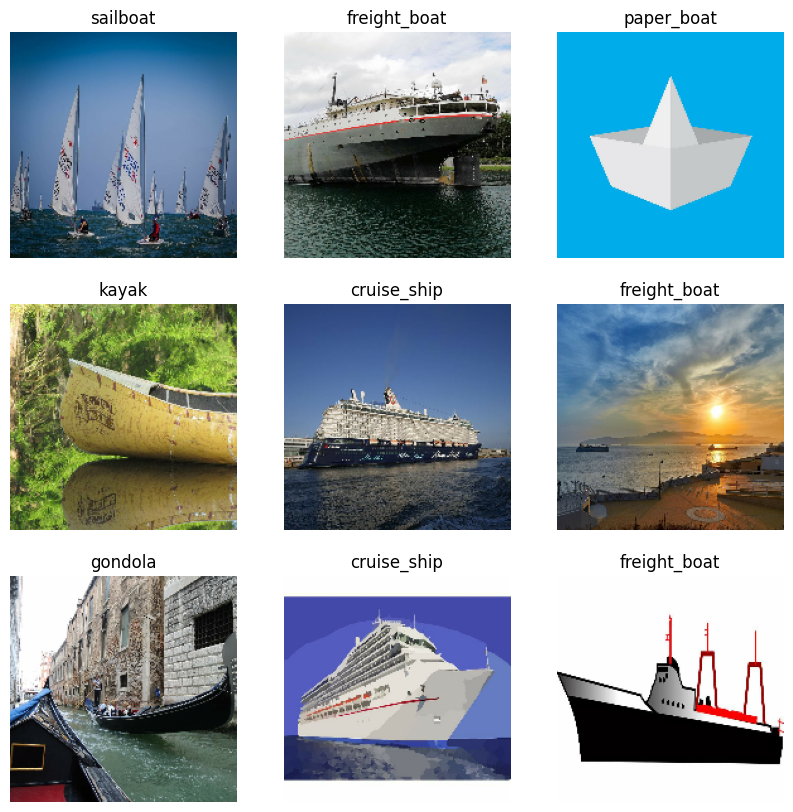

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [93]:
# AUTOTUNE
# cache() method
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [94]:
from tensorflow.keras.layers import Rescaling

In [96]:
normalization_layer = Rescaling(1/256)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00072318537 0.98723465


# Data Augmentation

In [97]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom,MaxPooling2D, Flatten,Dropout

In [98]:
model = Sequential()
model.add(RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(Rescaling(1/255))
model.add(Conv2D(16, 3, padding='same', activation='relu')) # yes padding
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu')) #  yes padding
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu')) # yes padding
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [99]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 6, 8, 1, 8, 8, 8, 4, 2, 8, 8, 8, 8, 5, 1, 1, 6, 7, 1, 2, 8, 1,
       8, 7, 8, 4, 4, 8, 8, 4, 1, 8], dtype=int32)>

In [102]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [103]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.0550 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0409 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0431 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0318 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0426 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0399 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0615 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0505 - loss: nan - val_accuracy: 0.0517 - val_loss: nan
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27

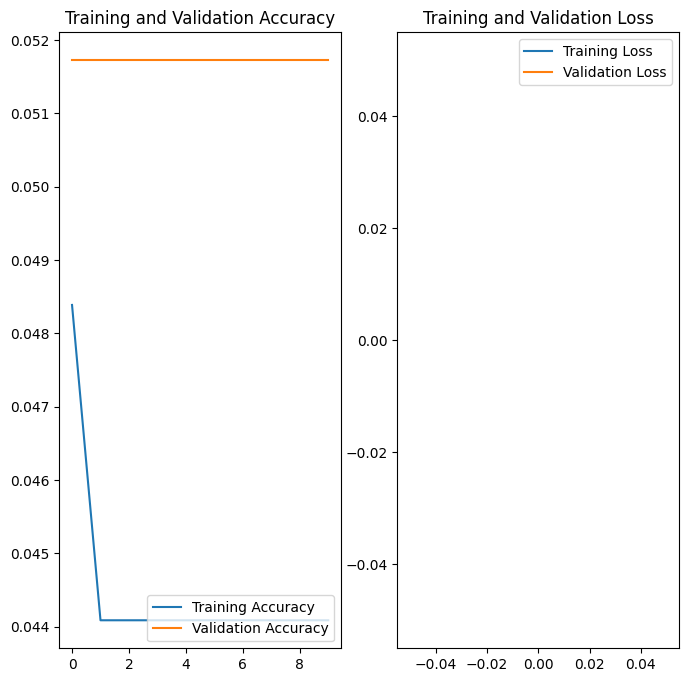

In [104]:
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [111]:
import PIL
img = PIL.Image.open(sailboats[0])
new_size = (img_width, img_height)  # Set your desired width and height
img_resized = img.resize(new_size)
img_array = tf.keras.utils.img_to_array(img_resized) # convert the PIL format to array
img_array.shape

(180, 180, 3)

In [112]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array.shape

TensorShape([1, 180, 180, 3])

In [113]:
predictions = model.predict(img_array)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


array([[nan, nan, nan, nan, nan]], dtype=float32)

In [114]:
np.argmax(predictions)

0

In [115]:
class_names[np.argmax(predictions)]

'buoy'